<a href="https://colab.research.google.com/github/mlites/mlites2019/blob/master/intro_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Linear Regression and Gradient Descent

Hello! In this exercise we'll peek behind the scenes at the deceptively simple linear regression algoritm by implementing a gradient descent algorithm

Along the way we'll learn to do some data manipulation in python using Pandas and NumPy, and learn how to separate our data into Training and Test sets for validation.

If you haven't already, make sure you run intro_kaggle.ipynb to download the necessary datasets


More background on linear regression
* [Introduction to Machine Learning Algorithms: Linear Regression](https://towardsdatascience.com/introduction-to-machine-learning-algorithms-linear-regression-14c4e325882a)


## Outline

1. import necessary packages
2. Load Iditarod data
3. Do some date and time conversion
4. Generate some new features
5. Plot some data

In [0]:
import pandas as pd #import Pandas under the shortcut 'pd'
import numpy as np #import NumPy; NumPy is the fundamental package for scientific computing with Python
import matplotlib.pyplot as plt #MatPlotLib is a plotting library

In [51]:
# first lets load the Iditarod data into a pandas dataframe in a variable called 'iditarod'

iditarod = pd.read_csv("iditarod.csv")
iditarod.tail()

,Number,Name,Status,Country,Checkpoint,Latitude,Longitude,Distance,Time,Speed,Arrival Date,Arrival Time,Arrival Dogs,Elapsed Time,Departure Date,Departure Time,Departure Dogs
1141,43,Jimmy Lebling,Rookie,United States,Nome,64.4964,-165.3996,22.0,2.95,7.46,03/18/2017,12:19:06,12.0,0.0,NaN,NaN,NaN
1142,47,Paul Hansen,Rookie,United States,Nome,64.4964,-165.3996,22.0,3.07,7.17,03/18/2017,14:19:11,12.0,0.0,NaN,NaN,NaN
1143,35,Alan Eischens,Veteran,United States,Nome,64.4964,-165.3996,22.0,3.50,6.29,03/18/2017,14:39:46,16.0,0.0,NaN,NaN,NaN
1144,53,Peter Reuter,Rookie,United States,Nome,64.4964,-165.3996,22.0,3.60,6.11,03/18/2017,14:45:38,9.0,0.0,NaN,NaN,NaN
1145,31,Cindy Abbott,Veteran,United States,Nome,64.4964,-165.3996,22.0,3.07,7.17,03/18/2017,14:57:31,12.0,0.0,NaN,NaN,NaN


Here we can see there is a bunch of data here about each musher, like when they arrived at each checkpoint, how long it took, what their speed was, and how many dogs they checked in or out

Let's explore the data a bit to see what it looks like. Say we're interested in how the number of dogs on the team affects the speed, we can plot that using the MatPlotLib library.

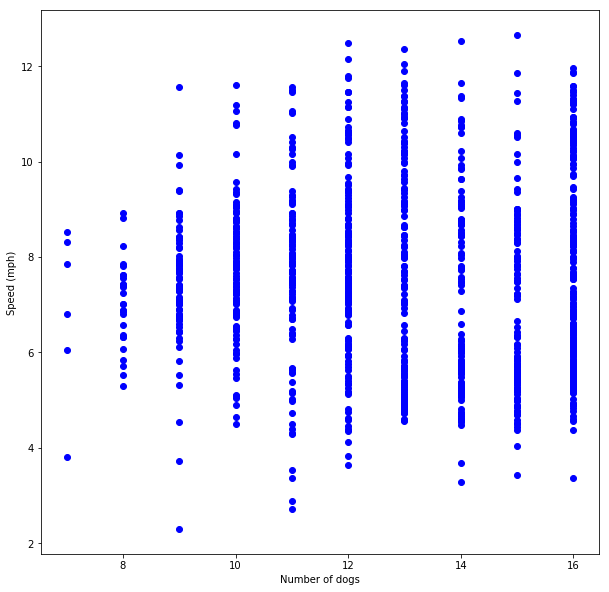

In [52]:
plt.figure(figsize=(10,10)) #set the figure size in inches
plt.scatter(iditarod["Arrival Dogs"],iditarod["Speed"],color='blue') # the scatter command make a scatter plot
plt.xlabel("Number of dogs")
plt.ylabel("Speed (mph)")
plt.show()

What do you think, is there a trend?

Do mushers go faster when they have more dogs?

What other factors might affect their speed?

Let's the Date and Time into a single object, Datetime

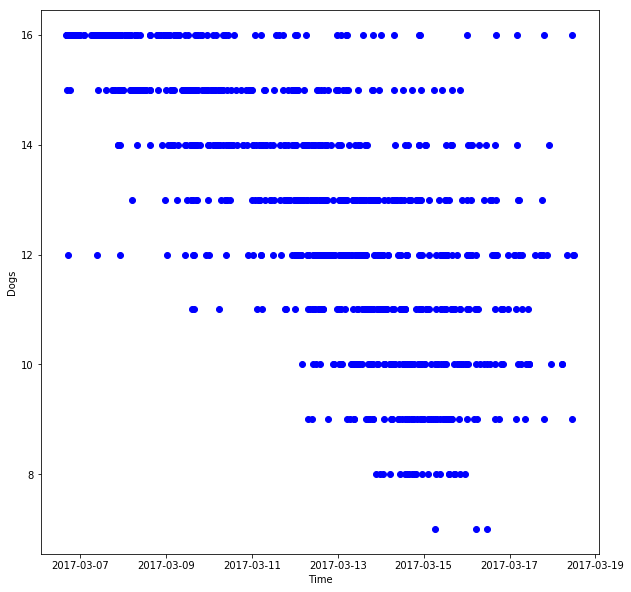

In [53]:

#let's drop values that have NA or NaN's
iditarod = iditarod.dropna()

#then convert the timestamps into a machine-readable timestamps

# import the datetime module
from datetime import datetime

# and get the Date and Time into a new dataframe

dt = iditarod.loc[:, ['Arrival Date', 'Arrival Time']] # : means 'all rows'

# this applies an anonymouse function ('lambda') to each row (axis=1) of the new dataframe
# that concatenates the Date and Time and converts them into a special 'datetime' object
# this then gets saved back into the iditarod dataframe

iditarod['Arrival_datetime'] = dt.apply(lambda x: datetime.strptime(x[0]+'/'+x[1], '%m/%d/%Y/%H:%M:%S'), axis=1)

# another way to make datetime objects in pandas
# iditarod["Arrival Time"] = pd.DatetimeIndex(iditarod["Arrival Time"],dtype='datetime64[ns]')
# iditarod["Departure Time"] = pd.DatetimeIndex(iditarod["Departure Time"],dtype='datetime64[ns]')

# now we can plot the number of Dogs as a function of the Datetime
# plot_data is a matplotlib command to use when you're plotting a date or time
plt.figure(figsize=(10,10)) #set the figure size in inches
plt.plot_date(iditarod["Arrival_datetime"],iditarod["Arrival Dogs"],color='blue') #make a scatter plot
plt.xlabel("Time")
plt.ylabel("Dogs")
plt.show()


Is there a trend here?

It kind of looks like it, but how can we tell for sure?

Let's look at one more example.

In [54]:
# it might be nice to know the cumulative time and distance traveleled to each checkpoint

# we can find the unique checkpoints like this:
iditarod["Checkpoint"].unique()

# then from the Iditarod website we can find the cumulative distances
# https://iditarod.com/race-map/

# and input them into a new dictionary like so:
cumulative_dist = {
'Fairbanks'	: 0,
'Nenana'	: 71,
'Manley'	: 161,
'Tanana'	: 227,
'Ruby'	: 346,
'Galena'	: 396,
'Huslia'	: 478,
'Koyukuk'	: 564,
'Nulato'	: 586,
'Kaltag'	: 633,
'Unalakleet'	: 718,
'Shaktoolik'	: 758,
'Koyuk'	: 808,
'Elim'	: 856,
'White Mountain'	: 902,
'Safety'	: 957,
'Nome'	: 979
}

# now we can the insert those into the iditarod dataframe using the 'replace' function like so:
iditarod["Cumulative_distance"] = iditarod["Checkpoint"].replace(cumulative_dist)

# finally lets convert the timestamps into hours elapsed since the the start of the race
# the .astype() function reports the time difference in hours
racestart = pd.Timestamp('2017-03-06 12:00:00.00000')
iditarod["Cumulative_hours"] = (iditarod["Arrival_datetime"]-racestart).astype('timedelta64[h]')

# now let's take a look at our new features
iditarod.head()

,Number,Name,Status,Country,Checkpoint,Latitude,Longitude,Distance,Time,Speed,Arrival Date,Arrival Time,Arrival Dogs,Elapsed Time,Departure Date,Departure Time,Departure Dogs,Arrival_datetime,Cumulative_distance,Cumulative_hours
72,6,Linwood Fiedler,Veteran,United States,Nenana,64.5952,-149.0897,60.0,5.05,11.88,03/06/2017,16:11:00,16.0,3.93,03/06/2017,20:07:00,16.0,2017-03-06 16:11:00,71,4.0
73,5,Cody Strathe,Veteran,United States,Nenana,64.5952,-149.0897,60.0,5.22,11.50,03/06/2017,16:19:00,16.0,0.12,03/06/2017,16:26:00,16.0,2017-03-06 16:19:00,71,4.0
74,4,Misha Wiljes,Rookie,Czech Republic,Nenana,64.5952,-149.0897,60.0,5.25,11.43,03/06/2017,16:19:00,15.0,5.93,03/06/2017,22:15:00,15.0,2017-03-06 16:19:00,71,4.0
75,9,Michelle Phillips,Veteran,Canada,Nenana,64.5952,-149.0897,60.0,5.18,11.58,03/06/2017,16:25:00,16.0,3.48,03/06/2017,19:54:00,16.0,2017-03-06 16:25:00,71,4.0
76,15,Martin Buser,Veteran,United States,Nenana,64.5952,-149.0897,60.0,5.02,11.96,03/06/2017,16:27:00,16.0,0.23,03/06/2017,16:41:00,16.0,2017-03-06 16:27:00,71,4.0


Ok, your turn!

Make a scatter plot of the elapsed time as a function of the distance traveled

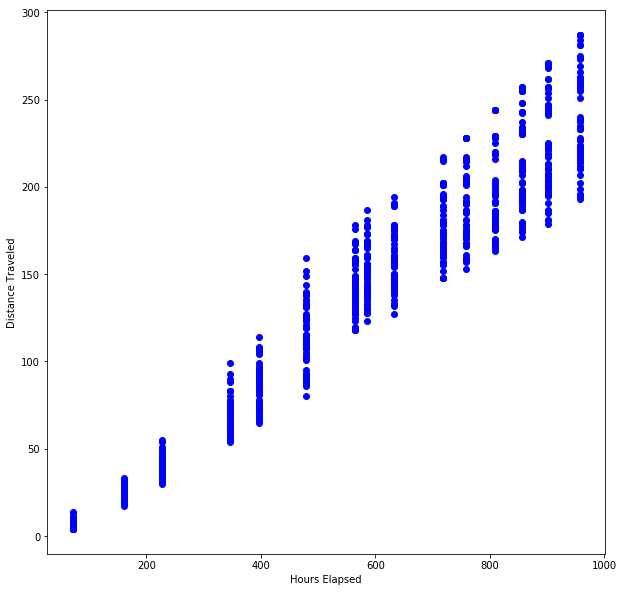

In [56]:
plt.figure(figsize=(10,10)) #set the figure size in inches
plt.scatter(iditarod["Cumulative_distance"],iditarod["Cumulative_hours"],color='blue') #make a scatter plot
plt.xlabel("Hours Elapsed")
plt.ylabel("Distance Traveled")
plt.show()

In [0]:

df_train = pd.read_csv('/Users/rohith/Documents/Datasets/Linear_Regression/train.csv')
df_test = pd.read_csv('/Users/rohith/Documents/Datasets/Linear_Regression/test.csv')

x_train = df_train['x']
y_train = df_train['y']
x_test = df_test['x']
y_test = df_test['y']

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

x_train = x_train.reshape(-1,1)
x_test = x_test.reshape(-1,1)


In [0]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score

clf = LinearRegression(normalize=True)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(r2_score(y_test,y_pred))


In [0]:
## Linear Regression 
import numpy as np

n = 700
alpha = 0.0001

a_0 = np.zeros((n,1))
a_1 = np.zeros((n,1))

epochs = 0
while(epochs < 1000):
    y = a_0 + a_1 * x_train
    error = y - y_train
    mean_sq_er = np.sum(error**2)
    mean_sq_er = mean_sq_er/n
    a_0 = a_0 - alpha * 2 * np.sum(error)/n 
    a_1 = a_1 - alpha * 2 * np.sum(error * x_train)/n
    epochs += 1
    if(epochs%10 == 0):
        print(mean_sq_er)

In [0]:
y_prediction = a_0 + a_1 * x_test
print('R2 Score:',r2_score(y_test,y_prediction))

y_plot = []
for i in range(100):
    y_plot.append(a_0 + a_1 * i)
plt.figure(figsize=(10,10))
plt.scatter(x_test,y_test,color='red',label='GT')
plt.plot(range(len(y_plot)),y_plot,color='black',label = 'pred')
plt.legend()
plt.show()